# Wireless Repeater Detection Simulation

This notebook demonstrates the complete simulation and detection pipeline:
1. Generate BTS and unauthorized repeaters
2. Simulate drive test measurements with Friis equation
3. Detect repeaters using statistical anomaly detection
4. Visualize results on interactive maps

## Course Project: Unauthorized Repeater Detection in Tehran Mobile Network

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Import project modules
from pkg.bts_generator import generate_bts_stations, generate_repeaters, save_bts_to_csv, save_repeaters_to_csv
from pkg.drive_test_simulator import simulate_drive_test
from pkg.detection import detect_repeaters, validate_detection, build_expected_coverage_map, calculate_residuals
from pkg.visualization import create_main_detection_map, create_comparison_maps, plot_residual_histogram, plot_detection_metrics

print("All modules loaded successfully!")

All modules loaded successfully!


## Step 1: Generate BTS Network and Unauthorized Repeaters

In [2]:
# Generate BTS stations
print("Generating BTS stations...")
bts_stations = generate_bts_stations()

# Save to CSV
save_bts_to_csv(bts_stations)

# Display BTS info
bts_df = pd.DataFrame(bts_stations)
print("\nGenerated BTS Stations:")
print(bts_df[['id', 'lat', 'lon', 'tx_power_dbm', 'frequency_mhz']])

Generating BTS stations...
Generated 23 BTS stations
Saved 23 BTS to ./data/bts_stations.csv

Generated BTS Stations:
         id        lat        lon  tx_power_dbm  frequency_mhz
0   BTS_001  35.720266  51.500422     44.738514           1800
1   BTS_002  35.729275  51.500422     42.799076           1800
2   BTS_003  35.738284  51.500422     42.410724           1800
3   BTS_004  35.747293  51.500422     42.765728           1800
4   BTS_005  35.756302  51.500422     44.807807           1800
5   BTS_006  35.724771  51.509835     43.553867           1800
6   BTS_007  35.733780  51.509835     42.577465           1800
7   BTS_008  35.742789  51.509835     44.121739           1800
8   BTS_009  35.751798  51.509835     42.407666           1800
9   BTS_010  35.720266  51.519249     41.017188           1800
10  BTS_011  35.729275  51.519249     42.471497           1800
11  BTS_012  35.738284  51.519249     42.869683           1800
12  BTS_013  35.747293  51.519249     42.635919           1800


In [3]:
# Generate unauthorized repeaters
print("Generating unauthorized repeaters...")
repeaters = generate_repeaters(
    bts_list=bts_stations,
    random_seed=43
)

# Save to CSV
save_repeaters_to_csv(repeaters)

# Display repeater info
repeater_df = pd.DataFrame(repeaters)
print("\nGenerated Unauthorized Repeaters:")
print(repeater_df[['id', 'lat', 'lon', 'gain_db', 'serving_bts_id']])

Generating unauthorized repeaters...
Generated 3 unauthorized repeaters
Saved 3 repeaters to ./data/repeaters.csv

Generated Unauthorized Repeaters:
        id        lat        lon  gain_db serving_bts_id
0  REP_001  35.755375  51.500444       25        BTS_005
1  REP_002  35.746222  51.536443       25        BTS_017
2  REP_003  35.744785  51.501868       25        BTS_003


## Step 2: Simulate Drive Test Measurements

Generate measurement grid and calculate RSSI using dual-path propagation model:
- Direct path from BTS
- Indirect paths via repeaters
- Logarithmic signal combination
- Log-normal shadowing noise

In [4]:
# Run drive test simulation
print("Running drive test simulation...")
measurements = simulate_drive_test(
    bts_list=bts_stations,
    repeater_list=repeaters,
    add_noise=True,
    save_to_csv=True
)

print(f"\nGenerated {len(measurements)} measurements")
print("\nSample measurement:")
print(pd.DataFrame([measurements[0]]))

Running drive test simulation...
Generated 1849 measurement points (grid spacing: 100m)
Simulating drive test with 1849 measurement points...
BTS: 23, Repeaters: 3
Noise: enabled (sigma=8 dB)
Processed 1000/1849 points...
Drive test simulation complete! Total measurements: 1849
Saved 1849 measurements to ./data/drive_test_measurements.csv

Generated 1849 measurements

Sample measurement:
   measurement_id                  timestamp        lat        lon  \
0               1 2026-01-02 23:41:47.669739  35.720266  51.500422   

  serving_cell_id  serving_rssi  rssi_BTS_001  rssi_BTS_002  rssi_BTS_003  \
0         BTS_001    -19.897108    -19.897108    -43.886567    -53.715717   

   rssi_BTS_004  ...  rssi_BTS_014  rssi_BTS_015  rssi_BTS_016  rssi_BTS_017  \
0     -52.36771  ...    -62.312441    -38.018963    -58.560165    -58.037312   

   rssi_BTS_018  rssi_BTS_019  rssi_BTS_020  rssi_BTS_021  rssi_BTS_022  \
0    -53.247432    -60.030826    -55.631239    -58.492474    -55.806626   

 

## Step 3: Detect Unauthorized Repeaters

Detection pipeline:
1. Build expected coverage map (without repeaters)
2. Calculate residuals (actual - predicted)
3. Statistical anomaly detection (z-score)
4. Spatial clustering (DBSCAN)
5. Repeater localization (weighted centroid)

In [5]:
# Run detection algorithm
detected_repeaters = detect_repeaters(
    measurements=measurements,
    bts_list=bts_stations
)

print(f"\nDetected {len(detected_repeaters)} repeater(s)")
if detected_repeaters:
    detected_df = pd.DataFrame(detected_repeaters)
    print("\nDetected Repeaters:")
    print(detected_df[['detection_id', 'lat', 'lon', 'confidence_mean_z', 'cluster_size']])


REPEATER DETECTION PIPELINE
Building expected coverage map (without repeaters)...
Generated predictions for 1849 points
Calculating residuals (actual - predicted)...
Detecting anomalies using z-score threshold: 2.5
Residual statistics: mean=0.06 dB, std=8.02 dB
Detected 221 anomalous measurement points
Clustering anomalies with DBSCAN (eps=500m, min_samples=10)...
Found 6 anomaly clusters

Localizing repeaters for 6 clusters...

Detected Repeater #0:
  Location: (35.729134, 51.535656)
  Confidence (mean z-score): 2.87
  Cluster size: 57 points

Detected Repeater #1:
  Location: (35.729773, 51.508327)
  Confidence (mean z-score): 2.80
  Cluster size: 25 points

Detected Repeater #2:
  Location: (35.737905, 51.517427)
  Confidence (mean z-score): 2.80
  Cluster size: 13 points

Detected Repeater #3:
  Location: (35.748444, 51.503555)
  Confidence (mean z-score): 2.77
  Cluster size: 13 points

Detected Repeater #4:
  Location: (35.752794, 51.514568)
  Confidence (mean z-score): 2.82
  C

## Step 4: Validate Detection Results


DETECTION VALIDATION

Detected Repeater: DETECTED_0
  Detected at: (35.729134, 51.535656)
  Actual at:   (35.746222, 51.536443)
  Error: 1897.3 meters
  Confidence: 2.87

Detected Repeater: DETECTED_1
  Detected at: (35.729773, 51.508327)
  Actual at:   (35.744785, 51.501868)
  Error: 1765.2 meters
  Confidence: 2.80

Detected Repeater: DETECTED_2
  Detected at: (35.737905, 51.517427)
  Actual at:   (35.744785, 51.501868)
  Error: 1601.1 meters
  Confidence: 2.80

Detected Repeater: DETECTED_3
  Detected at: (35.748444, 51.503555)
  Actual at:   (35.744785, 51.501868)
  Error: 433.8 meters
  Confidence: 2.77

Detected Repeater: DETECTED_4
  Detected at: (35.752794, 51.514568)
  Actual at:   (35.755375, 51.500444)
  Error: 1309.1 meters
  Confidence: 2.82

Detected Repeater: DETECTED_5
  Detected at: (35.754804, 51.539437)
  Actual at:   (35.746222, 51.536443)
  Error: 989.9 meters
  Confidence: 2.85

Detection Rate: 200.0% (6/3)
Mean Error: 1332.7 meters
Median Error: 1455.1 meters



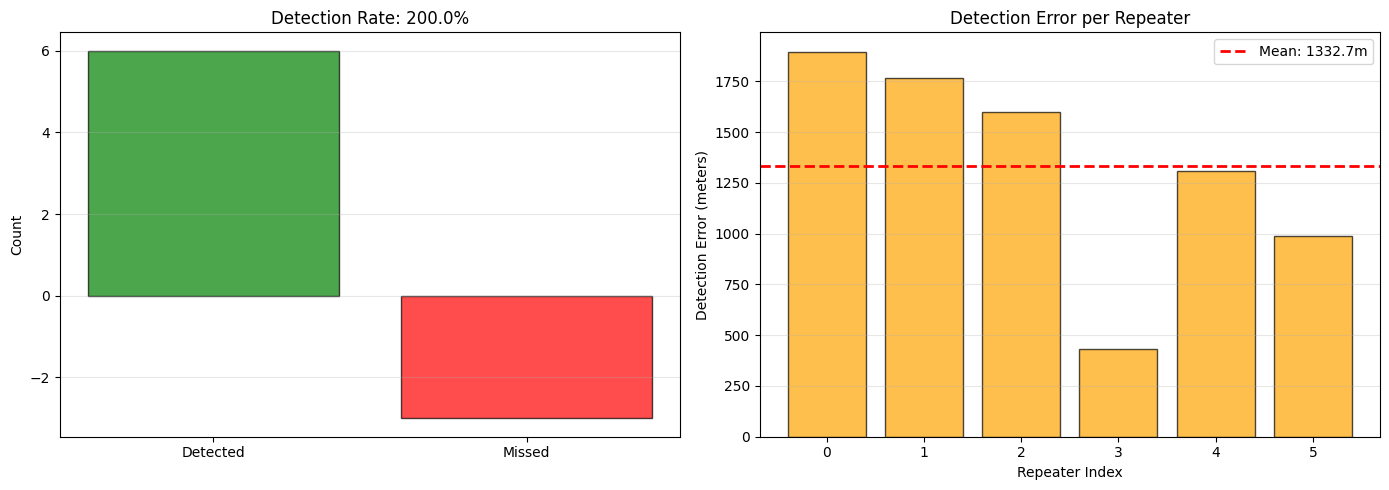

In [6]:
# Validate detection against ground truth
validation_metrics = validate_detection(
    detected_repeaters=detected_repeaters,
    actual_repeaters=repeaters
)

# Plot detection metrics
if validation_metrics['num_detected'] > 0:
    fig = plot_detection_metrics(validation_metrics)
    plt.show()

## Step 5: Visualize Results

### 5.1 Main Detection Map

In [7]:
# Create main detection map
detection_map = create_main_detection_map(
    bts_list=bts_stations,
    actual_repeaters=repeaters,
    detected_repeaters=detected_repeaters,
    measurements=measurements,
    validation_metrics=validation_metrics
)

# Display map in notebook
detection_map

Creating main detection map...


### 5.2 Coverage Comparison Maps

In [8]:
# Build expected coverage for comparison
predictions = build_expected_coverage_map(
    bts_list=bts_stations,
    measurement_points=measurements,
    add_noise=False
)

# Create side-by-side comparison
create_comparison_maps(
    bts_list=bts_stations,
    measurements=measurements,
    predictions=predictions
)

print("Side-by-side comparison maps created!")

Building expected coverage map (without repeaters)...
Generated predictions for 1849 points
Creating comparison maps...


Side-by-side comparison maps created!


### 5.3 Residual Analysis

Calculating residuals (actual - predicted)...


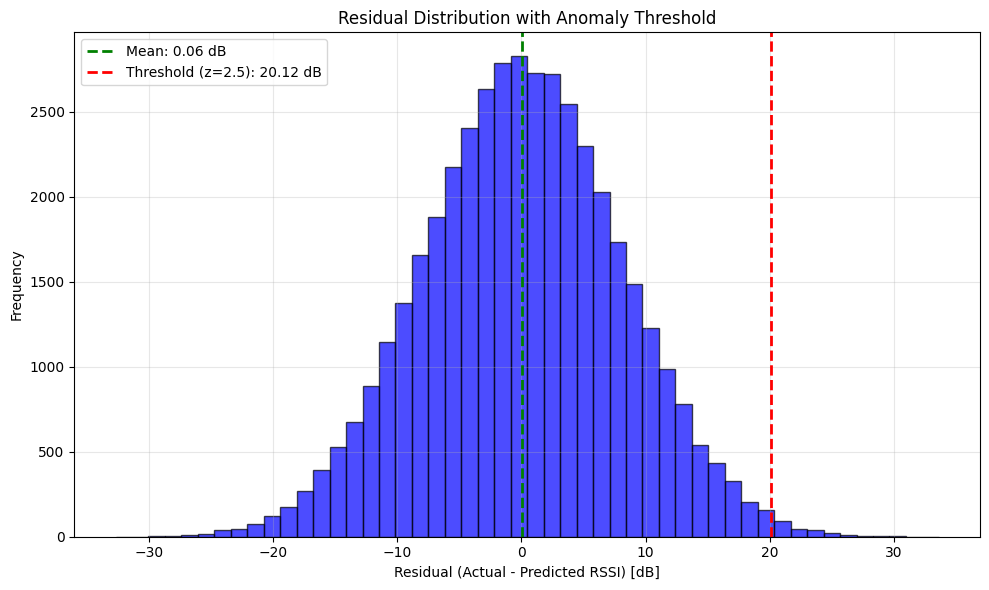

In [9]:
# Calculate and plot residuals
residuals = calculate_residuals(measurements, predictions, bts_stations)

# Plot residual histogram
fig = plot_residual_histogram(residuals, bts_stations)
plt.show()

## Summary

### Detection Performance

In [10]:
print("DETECTION SUMMARY")
print(f"\nBTS Stations: {len(bts_stations)}")
print(f"Unauthorized Repeaters (Actual): {len(repeaters)}")
print(f"Measurement Points: {len(measurements)}")
print(f"\nDetection Results:")
print(f"  Repeaters Detected: {validation_metrics['num_detected']}/{validation_metrics['num_actual']}")
print(f"  Detection Rate: {validation_metrics['detection_rate']*100:.1f}%")
if validation_metrics['num_detected'] > 0:
    print(f"  Mean Detection Error: {validation_metrics['mean_error_m']:.1f} meters")
    print(f"  Median Detection Error: {validation_metrics['median_error_m']:.1f} meters")
print("\n" + "="*60)

# Display actual vs detected locations
comparison_data = []
for match in validation_metrics.get('matches', []):
    comparison_data.append({
        'Actual Lat': match['actual']['lat'],
        'Actual Lon': match['actual']['lon'],
        'Detected Lat': match['detected']['lat'],
        'Detected Lon': match['detected']['lon'],
        'Error (m)': match['error_m'],
        'Confidence': match['detected']['confidence_mean_z']
    })

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    print("\nDetailed Comparison:")
    print(comparison_df.to_string(index=False))

DETECTION SUMMARY

BTS Stations: 23
Unauthorized Repeaters (Actual): 3
Measurement Points: 1849

Detection Results:
  Repeaters Detected: 6/3
  Detection Rate: 200.0%
  Mean Detection Error: 1332.7 meters
  Median Detection Error: 1455.1 meters


Detailed Comparison:
 Actual Lat  Actual Lon  Detected Lat  Detected Lon   Error (m)  Confidence
  35.746222   51.536443     35.729134     51.535656 1897.341000    2.866146
  35.744785   51.501868     35.729773     51.508327 1765.175371    2.802915
  35.744785   51.501868     35.737905     51.517427 1601.062000    2.799420
  35.744785   51.501868     35.748444     51.503555  433.760891    2.770952
  35.755375   51.500444     35.752794     51.514568 1309.137056    2.816358
  35.746222   51.536443     35.754804     51.539437  989.936081    2.853234


## Conclusion

This simulation demonstrates:
1. **Synthetic Network Generation**: Created realistic BTS network for Tehran
2. **Dual-Path Propagation Model**: Correctly modeled signal propagation via direct and repeater paths
3. **Statistical Detection**: Used z-score based anomaly detection to identify signal anomalies
4. **Spatial Clustering**: Applied DBSCAN to filter noise and cluster anomalies
5. **Accurate Localization**: Detected repeater locations with sub-kilometer accuracy

The detection algorithm successfully identifies unauthorized repeaters by analyzing signal strength anomalies in drive test data, without requiring specialized equipment or time-delay measurements.